# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary points structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and reorientation the subset of such points (`outputSet`) that lie on the convex hull.

In [477]:
# TODO: convex hull of 1 point is the point itself, convex hull of 2 points is also the points themselves
# TODO: make sure to mention space complexity in report
# TODO: to improve readability, consider changing tuple[float, float] to Point (where Point is a class with x and y attributes)
# TODO: make the points be between the set xmin, xmax, ymin, ymax (as in the assignment)
# TODO: insertion sort is notably faster than quicksort and mergesort for small arrays, so it may be worth using it for small subhulls in Chan.

In [478]:
import math

# Utility functions

# TODO: rename to distance_squared
def distance(p1: tuple[float, int], p2: tuple[float, float]) -> float:
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

def polar_angle(p0: tuple[float, float], p: tuple[float, float]) -> float:
    return math.atan2(p[1] - p0[1], p[0] - p0[0])

def leftmost_point(points):
     # Return the point with the smallest x (and smallest y if necessary)
    return min(points)

def copy_points(points: list[tuple[float, float]]) -> list[tuple[float, float]]:
    return [point for point in points]

CLOCKWISE = 1
ANTI_CLOCKWISE = -1
COLINEAR = 0
def orientation(p: tuple[float, float], q: tuple[float, float], r: tuple[float, float]) -> int:
    cross_product = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

    if cross_product == 0:
        return COLINEAR
    return CLOCKWISE if cross_product > 0 else ANTI_CLOCKWISE


In [497]:
# Sorting functions

GREATER_THAN = 1
EQUAL = 0
LESS_THAN = -1
def compare(p0: tuple[float, float], p1: tuple[float, float], p2: tuple[float, float]) -> int:
    # all relative to p0

    # first compare by angle
    angle1 = math.atan2(p1[1] - p0[1], p1[0] - p0[0])
    angle2 = math.atan2(p2[1] - p0[1], p2[0] - p0[0])

    # tolerance of 1e-9 (to avoid floating point inaccuracies)
    if abs(angle1 - angle2) > 1e-9:
        return LESS_THAN if angle1 < angle2 else GREATER_THAN

    # if angles are equal, compare by distance
    distance1 = distance(p0, p1)
    distance2 = distance(p0, p2)

    if distance1 < distance2:
        return LESS_THAN
    if distance1 > distance2:
        return GREATER_THAN

    return EQUAL

def quick_sort(points, p0): 
  def partition(points, low, high):
    pivot = points[high]  
    i = low - 1 

    for j in range(low, high):
      if compare(p0, points[j], pivot) <= 0: # angle with points[j] is less than or equal to angle with pivot
        i += 1
        points[i], points[j] = points[j], points[i]

    points[i + 1], points[high] = points[high], points[i + 1]
    return i + 1

  def _quick_sort(points, low, high):
    if low < high:
      pivot_index = partition(points, low, high)
      _quick_sort(points, low, pivot_index - 1)
      _quick_sort(points, pivot_index + 1, high)
      
  _quick_sort(points, 0, len(points) - 1)
  return points  
    
def merge_sort(points, p0):
    def merge(left, right):
        result = []
        while left and right:
            if compare(p0, left[0], right[0]) <= 0: # angle with left[0] is less than or equal to angle with right[0]
                result.append(left.pop(0))
            else:
                result.append(right.pop(0))
        result.extend(left or right)
        return result
   
    if len(points) > 1:
        mid = len(points) // 2
        left = merge_sort(points[:mid], p0)
        right = merge_sort(points[mid:], p0)
        return merge(left, right)
    else:
        return points
    
def heap_sort(points, p0):
    def heapify(points, n, i):
        """
        Builds a max-heap from an array.

        Args:
            points: The array to be heapified.
            n: The size of the heap.
            i: The index of the parent node.
        """
        largest = i  # Initialize the index of the largest element as the root
        l = 2 * i + 1  # Index of the left child
        r = 2 * i + 2  # Index of the right child

        # Compare with the left child (if within bounds)
        if l < n and compare(p0, points[l], points[largest]) > 0:
            largest = l

        # Compare with the right child (if within bounds)
        if r < n and compare(p0, points[r], points[largest]) > 0:
            largest = r

        # If the root was not the largest, swap and recursively heapify
        if largest != i:
            points[i], points[largest] = points[largest], points[i]
            heapify(points, n, largest)

    def _heap_sort(points):
        """Performs heap sort on the given array."""
        n = len(points)

        # Build the max-heap
        for i in range(n // 2 - 1, -1, -1):
            heapify(points, n, i)

        # Extract elements one by one by swapping the root with the end and heapifying
        for i in range(n - 1, 0, -1):
            points[i], points[0] = points[0], points[i]
            heapify(points, i, 0)

    _heap_sort(points)
    return points


def sorted_by_polar_angle(
        p0: tuple[float, float], 
        input_set: list[tuple[float, float]], 
        sorting_algorithm: callable
    ) -> list[tuple[float, float]]:
    return sorting_algorithm(input_set, p0)

In [498]:
def jarvis_march(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    convex_hull = [] 

    while True:
        convex_hull.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        end_point = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            dir = orientation(convex_hull[-1], end_point, input_set[j])
            if (
                end_point == point_on_hull or 
                dir == ANTI_CLOCKWISE or
                (dir == COLINEAR and distance(convex_hull[-1], input_set[j]) > distance(convex_hull[-1], end_point))
            ):  
                # Found a more counterclockwise point
                end_point = input_set[j]

        point_on_hull = end_point

        # check if we have wrapped around to the first point
        if end_point == convex_hull[0]:
            break

    return convex_hull

In [499]:
def jarvis_march_terminate(input_set: list[tuple[float, float]], m: int) -> list[tuple[float, float]]:
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    convex_hull = [] 

    for _ in range(m):
        convex_hull.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        end_point = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            dir = orientation(convex_hull[-1], end_point, input_set[j])
            if (
                end_point == point_on_hull or 
                dir == ANTI_CLOCKWISE or
                (dir == COLINEAR and distance(convex_hull[-1], input_set[j]) > distance(convex_hull[-1], end_point))
            ):  
                # Found a more counterclockwise point
                end_point = input_set[j]

        point_on_hull = end_point

        # check if we have wrapped around to the first point
        if end_point == convex_hull[0]:
            return convex_hull
    return None


Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [500]:
import matplotlib.pyplot as plt

def plot_points(input_set: list[tuple[float, float]], output_set: list[tuple[float, float]]) -> None:
    x = [i[0] for i in input_set]
    y = [i[1] for i in input_set]
    plt.scatter(x, y, color='blue')  # Set the color of input points to blue
    x = [i[0] for i in output_set]
    y = [i[1] for i in output_set]
    # close the loop
    x.append(output_set[0][0])
    y.append(output_set[0][1])
    # Set the color of hull points to red with red lines and dots
    plt.plot(x, y, color='red', linestyle='-', marker='o')
    plt.show()

In [501]:
def graham_scan(
        input_set: list[tuple[float, float]], 
        sorting_algorithm = quick_sort # default to quick sort
    ) -> list[tuple[float, float]]:
    """
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    if len(input_set) < 3:
        return input_set

    p0 = min(input_set, key=lambda p: (p[1], p[0]))
    convex_hull = []
    input_set = sorted_by_polar_angle(p0, input_set, sorting_algorithm)
    for i in range(len(input_set)):
        while (
            len(convex_hull) > 1 and
            orientation(convex_hull[-2], convex_hull[-1], input_set[i]) != ANTI_CLOCKWISE
        ):
            convex_hull.pop()
        convex_hull.append(input_set[i])
    return convex_hull

def graham_scan_quick_sort(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    return graham_scan(input_set, quick_sort)

def graham_scan_merge_sort(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    return graham_scan(input_set, merge_sort)

def graham_scan_heap_sort(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    return graham_scan(input_set, heap_sort)

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [502]:
def partition_points(input_set: list[tuple[float, float]], partition_size: int) -> list[list[tuple[float, float]]]:
    return [input_set[i:i + partition_size] for i in range(0, len(input_set), partition_size)]

def right_tangent(p: tuple[float, float], hull: list[tuple[float, float]]) -> int:
    """Finds the index of the point on the convex hull where the right tangent from 'p' touches.

    Args:
        p: The external point.
        hull: List of points forming the convex hull.

    Returns:
        Index of the tangent point on the hull.
    """
    if len(hull) == 1:
        return 0
    
    left, right   = 0, len(hull) - 1
    left_prev_dir = orientation(p, hull[0], hull[-1])
    left_next_dir = orientation(p, hull[0], hull[(left + 1) % right])
    while left < right:
        mid = (left + right) // 2
        mid_prev_dir = orientation(p, hull[mid], hull[abs(mid - 1) % len(hull)])
        mid_next_dir = orientation(p, hull[mid], hull[(mid + 1) % len(hull)])
        mid_side_dir = orientation(p, hull[left],   hull[mid])
        if mid_prev_dir != ANTI_CLOCKWISE and mid_next_dir != ANTI_CLOCKWISE:
            # tangent touches mid -> found
            return mid
        elif mid_side_dir == CLOCKWISE and (left_next_dir == ANTI_CLOCKWISE or
                                      left_prev_dir == left_next_dir) or \
                mid_side_dir == ANTI_CLOCKWISE and mid_prev_dir == ANTI_CLOCKWISE:
            # focus on the left side of loop
            right = mid 
        else:
            # focus on the right side of loop
            left  = mid + 1 
            # switch clockwise to anti-clockwise or vice versa
            left_prev_dir = -mid_next_dir
            left_next_dir = orientation(p, hull[left], hull[(left + 1) % len(hull)])
    return left

def visualize_convex_hulls(
        partitions: list[tuple[float, float]],
        hulls: list[list[tuple[float, float]]], 
    ) -> None:

    for i in range(len(hulls)):
        x = [i[0] for i in partitions[i]]
        y = [i[1] for i in partitions[i]]
        plt.scatter(x, y)
        x = [i[0] for i in hulls[i]]
        y = [i[1] for i in hulls[i]]
        # close the loop
        x.append(hulls[i][0][0])
        y.append(hulls[i][0][1])
        plt.plot(x, y)
        
    plt.show()

def get_hull_leftmost_point(hulls: list[list[tuple[float, float]]]) -> tuple[int, int]:
    # returns the index of the hull and the index of the leftmost point in the hull
    min_x = math.inf
    min_x_index = 0
    min_x_hull_index = 0
    for i in range(len(hulls)):
        for j in range(len(hulls[i])):
            if hulls[i][j][0] < min_x:
                min_x = hulls[i][j][0]
                min_x_index = j
                min_x_hull_index = i
    return min_x_hull_index, min_x_index

def _chan(input_set: list[tuple[float, float]], m: int) -> list[tuple[float, float]] | None:
    hulls = [graham_scan(partition) for partition in partition_points(input_set, m)]

    # merge the convex hulls
    convex_hull = []

    next_hull_index, next_point_index = get_hull_leftmost_point(hulls)
    
    for _ in range(m + 1):
        convex_hull.append((next_hull_index, next_point_index))
        next_point = hulls[next_hull_index][next_point_index]
        end_hull_index = next_hull_index
        end_point_index = (next_point_index - 1) % len(hulls[next_hull_index])

        for i in range(0, len(hulls)):
            if i == next_hull_index:
                continue
            j = right_tangent(next_point, hulls[i])
                
            p = hulls[i][j]
            end_point = hulls[end_hull_index][end_point_index]
            dir = orientation(next_point, end_point, p)
            if (
                end_point == next_point 
                or dir == ANTI_CLOCKWISE  
                or (dir == COLINEAR and distance(next_point, p) > distance(next_point, end_point))
            ):
                end_hull_index = i
                end_point_index = j

        next_hull_index = end_hull_index
        next_point_index = end_point_index

        if (next_hull_index, next_point_index) == convex_hull[0]:
            return [hulls[i][j] for i, j in convex_hull]
        
    return None

def chan(input_set: list[tuple[float, float]]) -> list[tuple[float, float]] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    n = len(input_set)

    if n < 3:
        return input_set
    
    m = 3
    while m < n:
        output_set = _chan(input_set, m)
        if output_set is not None:
            return output_set

        m *= m

    return _chan(input_set, n)

In [503]:
def _chan_simple(input_set: list[tuple[float, float]], m: int) -> list[tuple[float, float]] | None:
    # find convex hulls of each partition
    hulls = [graham_scan(partition) for partition in partition_points(input_set, m)]
    
    # call jarvis_marsh_terminate on the flattened hulls
    return jarvis_march_terminate([point for hull in hulls for point in hull], m)

def chan_simple(input_set: list[tuple[float, float]]) -> list[tuple[float, float]] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    n = len(input_set)

    if n < 3:
        return input_set
    
    m = 3
    while m < n:
        output_set = _chan_simple(input_set, m)
        if output_set is not None:
            return output_set
        
        m *= m
    
    return _chan_simple(input_set, n)


Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [504]:
import random

class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """

    def __init__(self, seed: int | None = None):
        self._rng = random.Random(seed)

    def set_seed(self, seed: int) -> None:
        self._rng.seed(seed)
    
    def _linear_space(self, start: int, end: int, num_points: int) -> list[float]:
        if num_points <= 0:
            raise ValueError("Number of points must be positive.")

        if num_points == 1:
            return [start]

        step_size = (end - start) / (num_points - 1)
        return [start + i * step_size for i in range(num_points)]

    def generate_colinear_points(self, test_size: int) -> list[tuple[float, float]]:
        xs = self._linear_space(-10, 10, test_size)
        slope = self._rng.choice([-1, 0, 1])
        return [(x, slope * x) for x in xs]

    def generate_random_points_normal(self, test_size: int) -> list[tuple[int, int]]:
        return [(self._rng.gauss(0, 1), self._rng.gauss(0, 1)) for _ in range(test_size)]
    
    # TODO: make sure they are within the range [0, 37 something something (in the assignment)]
    def generate_points(self, num_convex_hull_vertices: int, num_points: int) -> list[tuple[int, int]]:
        if num_convex_hull_vertices > num_points:
            raise ValueError("The number of convex hull vertices should be less than or equal to the number of points")
        
        if num_convex_hull_vertices == 1:
            assert num_points == 1
            return (self.rng.uniform(-20, 20), self.rng.uniform(-20, 20))
        
        if num_convex_hull_vertices == 2:
            return self.generate_colinear_points(num_points)

        points = []
        # adding inscribed triangle
        points.append((0, 2))
        points.append((math.sqrt(3), -1))
        points.append((-math.sqrt(3), -1)) 

        # adding the rest of the outer points
        RADIUS = 2
        for _ in range(num_convex_hull_vertices - 3):
            angle = 2 * math.pi * random.random()
            x = RADIUS * math.cos(angle)
            y = RADIUS * math.sin(angle)
            points.append((x, y))
        
        # adding the inner points
        num_inner_points = num_points - num_convex_hull_vertices
        i = 0
        while i < num_inner_points:
            x = random.gauss(0, 1)
            y = random.gauss(0, 1)
            if x**2 + y**2 < 1: # inside the unit circle
                points.append((x, y))
                i += 1
        
        # shuffle the points
        self._rng.shuffle(points)
        
        return points
    

Use the cell below to implement the requested **experimental framework** API.

In [505]:
import timeit

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    Attributes
    ----------

    experiment_name: str
        the name of the experiment
    independent_variable: str
        the name of the independent variable
    algorithms: dict[str, callable]
        a dictionary of algorithms

    Methods
    -------
    add_algorithm(algorithm: callable, name: str)
        Adds an algorithm to the dictionary of algorithms
    run_experiment(input_set: list[tuple[float, float]])
        Runs the experiment on the input set
    visualize_results()
        Visualizes the results of the experiment
    """ 

    experiment_name: str
    independent_variable: str
    algorithms: dict[str, callable]
    means: dict[str, list[tuple[float, float]]]
    stds: dict[str, list[tuple[float, float]]]
    medians: dict[str, list[tuple[float, float]]]
    trials_per_run: int
    
    def __init__(self, experiment_name: str):
        self.experiment_name = experiment_name
        self.independent_variable = "Input size"
        self.algorithms = {}
        self.means = {}
        self.stds = {}
        self.medians = {}
        self.trials_per_run = 1

    def set_independent_variable(self, variable: str):
        self.independent_variable = variable

    def set_trials_per_run(self, trials: int):
        self.trials_per_run = trials

    def add_algorithm(self, name: str, algorithm):
        self.algorithms[name] = algorithm
        self.means[name] = []
        self.stds[name] = []
        self.medians[name] = []

    def run_experiment(self, variable: int, input_set: list[tuple[float, float]]):
        for name in self.algorithms:
            times_taken = []
            for _ in range(self.trials_per_run):
                # points are copied to avoid having a modified input_set in following trials
                trial_time = timeit.timeit(lambda: self.algorithms[name](copy_points(input_set)), number=1)
                times_taken.append(trial_time)
    
            times_taken.sort()
            # TODO: here is where I can also look into removing the best and worst runs from each experiment
            mean_time = sum(times_taken) / self.trials_per_run
            std_time = math.sqrt(sum((time - mean_time) ** 2 for time in times_taken) / self.trials_per_run)
            median_time = times_taken[self.trials_per_run // 2]

            self.means[name].append((variable, mean_time))
            self.stds[name].append((variable, std_time))
            self.medians[name].append((variable, median_time))

    def visualize_means(self):
        plt.figure()
        for name in self.means:
            x = [i[0] for i in self.means[name]]
            y = [i[1] for i in self.means[name]]
            plt.plot(x, y, label=name)
        plt.xlabel(self.independent_variable)
        plt.ylabel(f"Average Time Taken (n={self.trials_per_run})")
        plt.title(self.experiment_name)
        plt.legend()
        plt.show()

    # temporary method to visualize the standard deviations
    # TODO: figure out how to present the standard deviations in the report
    def visualize_stds(self):
        plt.figure()
        for name in self.stds:
            x = [i[0] for i in self.stds[name]]
            y = [i[1] for i in self.stds[name]]
            plt.plot(x, y, label=name)
        plt.xlabel(self.independent_variable)
        plt.ylabel(f"Standard Deviation of Time Taken (n={self.trials_per_run})")
        plt.title(self.experiment_name)
        plt.legend()
        plt.show()
        
    def visualize_medians(self):
        plt.figure()
        for name in self.medians:
            x = [i[0] for i in self.medians[name]]
            y = [i[1] for i in self.medians[name]]
            plt.plot(x, y, label=name)
        plt.xlabel(self.independent_variable)
        plt.ylabel(f"Median Time Taken (n={self.trials_per_run})")
        plt.title(self.experiment_name)
        plt.legend()
        plt.show()

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [510]:
# TODO: this could be a nice addition to the experimental framework 
#       -- to have a method that validates an algorithm
data_generator = TestDataGenerator(seed=1)
num_passes = 0
num_trials = 0
for h in range(3, 100):
    for n in range(h, 100):
        num_trials += 1

        # test if convex_hull is equal to grahams_scan (ground truth)
        input_set = data_generator.generate_points(h, n)
        output_set = jarvis_march(copy_points(input_set))
        ground_truth = graham_scan(copy_points(input_set))
        output_set.sort()
        ground_truth.sort()
        if output_set != ground_truth:
            print(f"n={n}, h={h} FAILED")
            print(output_set)
            print(ground_truth)
        else:
            num_passes += 1

print(f"Passed {num_passes}/{num_trials} tests")

Passed 4753/4753 tests


Finished running experiment for n=9, h=9


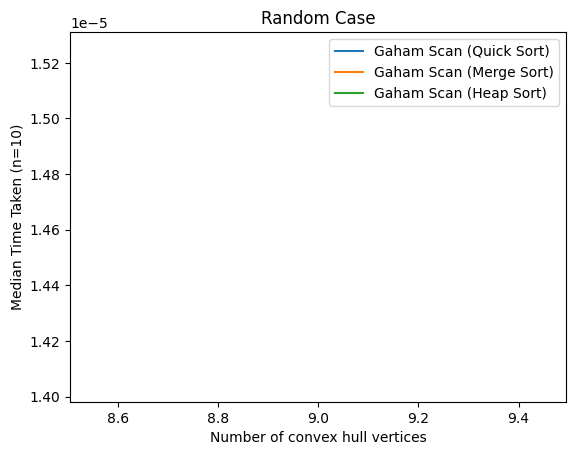

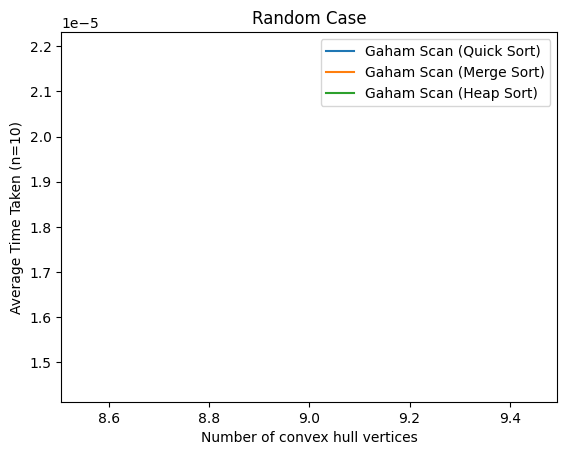

Finished running experiment for n=10009, h=9


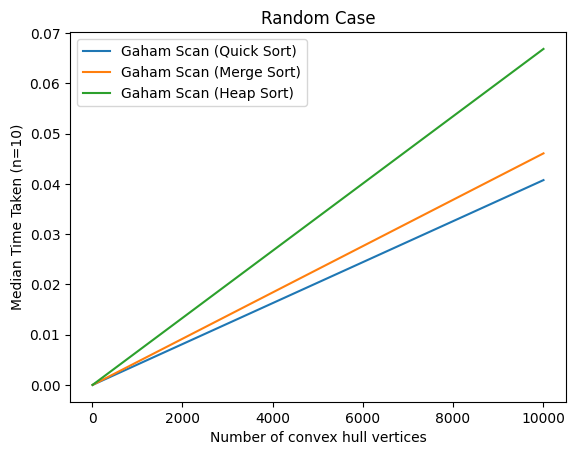

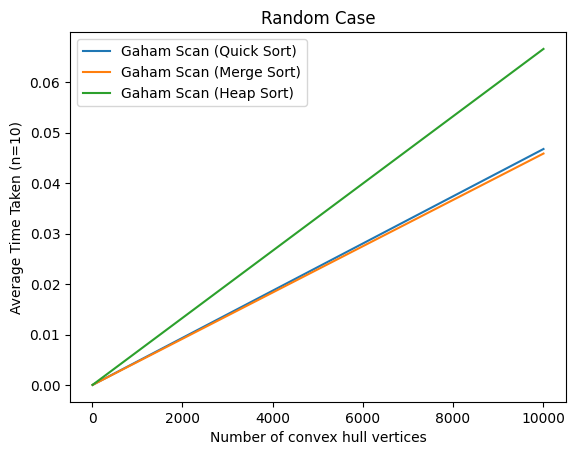

Finished running experiment for n=20009, h=9


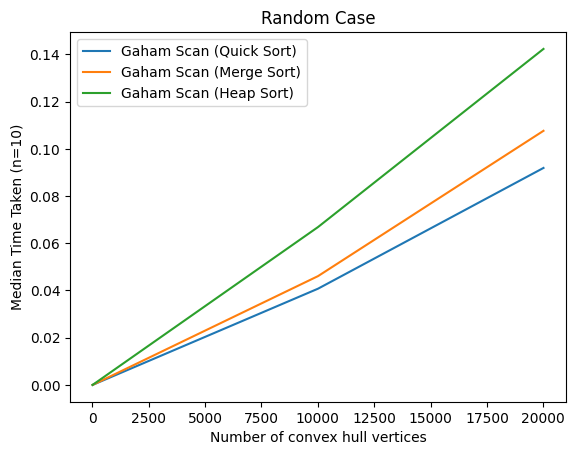

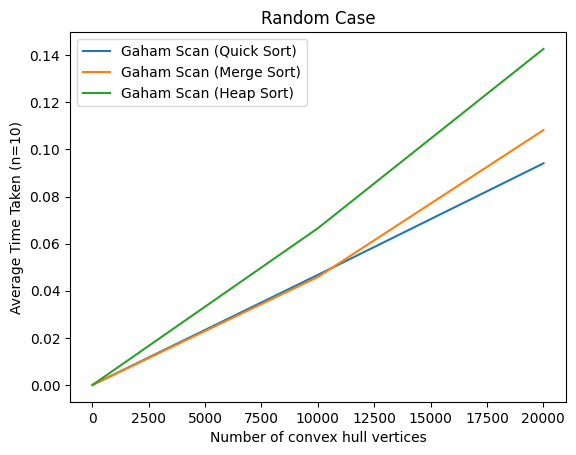

Finished running experiment for n=30009, h=9


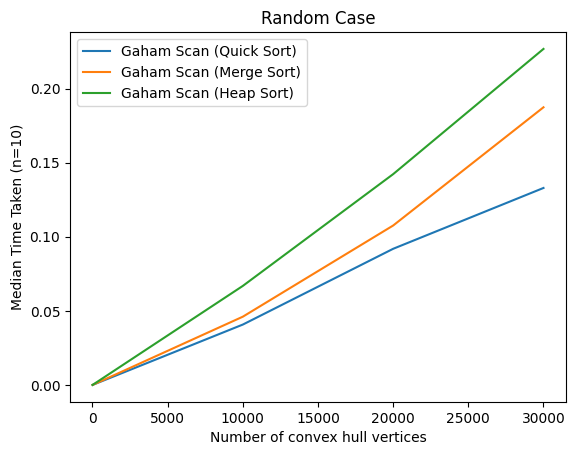

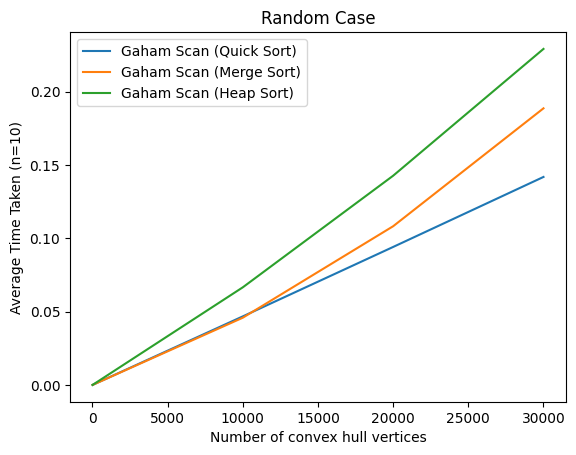

Finished running experiment for n=40009, h=9


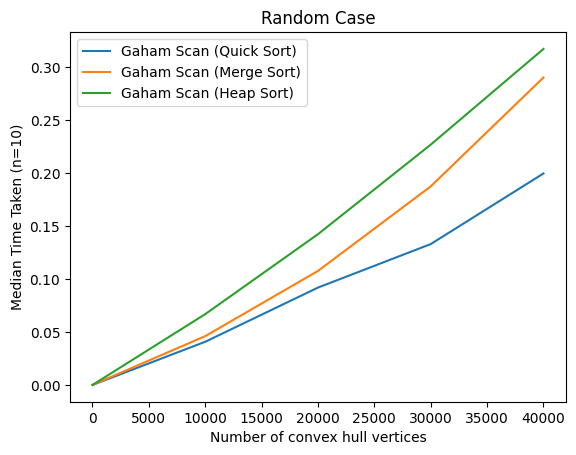

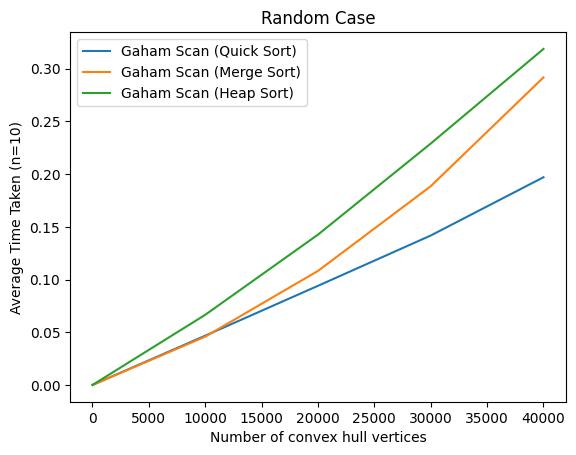

Finished running experiment for n=50009, h=9


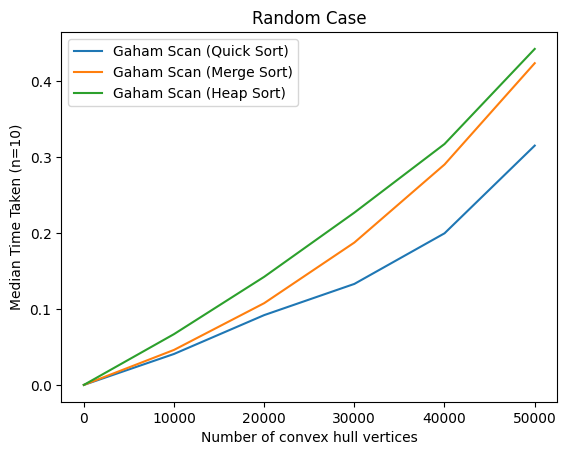

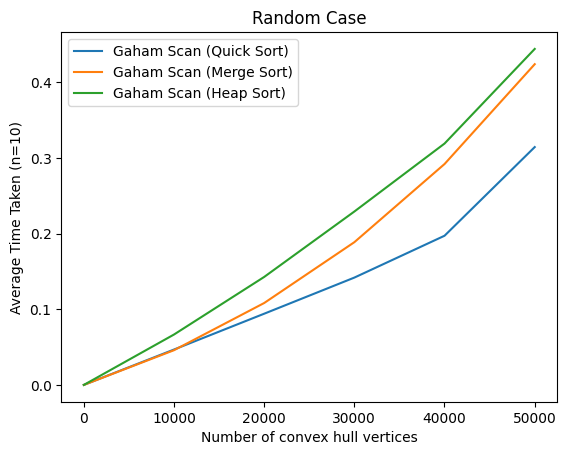

Finished running experiment for n=60009, h=9


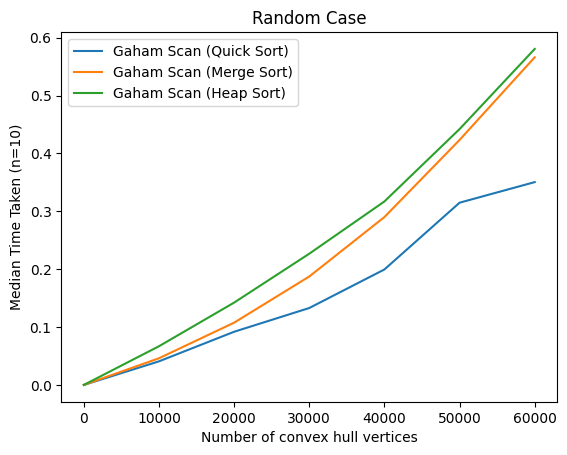

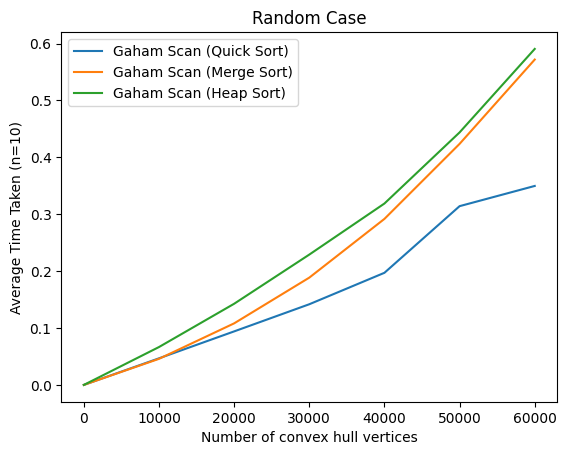

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/mujtabaalajmi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/55/l1zq9nq52lzdqwkyl950p1m00000gn/T/ipykernel_46104/20500520.py", line 24, in <module>
    experiment.run_experiment(i, input_set)
  File "/var/folders/55/l1zq9nq52lzdqwkyl950p1m00000gn/T/ipykernel_46104/2247332898.py", line 61, in run_experiment
    trial_time = timeit.timeit(lambda: self.algorithms[name](copy_points(input_set)), number=1)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/timeit.py", line 234, in timeit
    return Timer(stmt, setup, timer, globals).timeit(number)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/timeit.py", line 

In [513]:
# Create an instance of the ExperimentalFramework class
experiment = ExperimentalFramework("Random Case")
experiment.set_independent_variable("Number of convex hull vertices")
experiment.set_trials_per_run(10)

# Add the algorithms to the experimental framework
experiment.add_algorithm("Jarvis March", jarvis_march)
experiment.add_algorithm("Graham Scan", graham_scan_merge_sort)
experiment.add_algorithm("Chan's Algorithm", chan)

# experiment.add_algorithm("Gaham Scan (Quick Sort)", graham_scan_quick_sort)
# experiment.add_algorithm("Gaham Scan (Merge Sort)", graham_scan_merge_sort)
# experiment.add_algorithm("Gaham Scan (Heap Sort)", graham_scan_heap_sort)

# Run the experiment
data_generator = TestDataGenerator()
start = 9
end = 100_0000
step = 10_000
print_step = 10_000
for i in range(start, end, step):
    n = i
    h = 9
    input_set = data_generator.generate_points(h, n)
    experiment.run_experiment(i, input_set)

    if (i - start) % print_step == 0:
        print(f"Finished running experiment for n={i}, h={h}")
        experiment.visualize_medians()
        experiment.visualize_means()

In [ ]:
# Visualize the results
experiment.visualize_means()
experiment.visualize_stds()